In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csgraph
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import umap
from sklearn import linear_model
from collections import Counter
import sklearn
import scipy.stats as sps
from scipy.spatial.distance import cdist
from importlib import reload
import mygene

import gget

# locals
import utils as ut
reload(ut)

2023-03-20 09:36:07.969247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 09:36:08.079099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-03-20 09:36:08.079117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 09:36:08.104798: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-20 09:36:08.8883

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
%matplotlib inline

# basic projection (MacSpectrum)

In [3]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
xy['metaTypes'] = xy['cellTypes']
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors', 'metaTypes']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
HFD8...
HFD14...
done


# MacSpectrum-like projection

In [4]:
def getGroup(rna, labels, key, ctype):
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'] == ctype]['cellId'].to_list()
    return rf[rf.index.isin(cellIds)]

    
p1 = getGroup(rna, labels, 'ND', 'Mac1') # pole 1 is ATM
p2 = getGroup(rna, labels, 'HFD14', 'Mac5') # pole 2 is LAM
print(f"{p1.shape=} {p2.shape=}")

p1.shape=(136, 31053) p2.shape=(1870, 31053)


In [5]:
# get DEGS between groups

def getDEGs(p1, p2):
    """ get differential expression between p1, p2
    Note: columns assumed to bet the same
    """
    deg = []

    for g in p1.columns:
        score, pval = scipy.stats.ranksums(p1[g], p2[g],
                                   alternative='two-sided')

        lfc = np.log2(p1[g].mean()+0.001) - np.log2(p2[g].mean()+0.001)

        row = {
            'gene' : g,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meanP1' : p1[g].mean(),
            'propP1' : p1[g].astype(bool).sum() / len(p1),
            'meanP2' : p2[g].mean(),
            'propP2' : p2[g].astype(bool).sum() / len(p2),
        }

        deg.append(row)

    deg = pd.DataFrame(deg)
    return deg 


deg = getDEGs(p1, p2)
deg.head()

,gene,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,XKR4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,GM1992,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,GM37381,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,RP1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,SOX17,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def getSig(deg, alpha, n, p=None, method='log2foldchange'):
    """get significant genes from deg 
    
    alpha: the significance level before correction
    n: number of genes for each group 
    p: the percentage of cells that must express the gene (from each group)
    """
    ntests = deg['gene'].nunique()
    alphaHat = 1 - ((1-alpha) ** (1/ntests))
    print(f"{alpha=} {ntests=} {alphaHat}")


    sig = deg[deg['pval'] < alphaHat].reset_index()
    
    if not p is None:
        sig = sig[(sig['propP1'] > p) | (sig['propP2'] > p)]

    """ gene sorting method """
    if method == 'log2foldchange': # sort by high-low logfold change
        n = int(n/2) # taking from top and bottom 
        sig = sig.sort_values(by='log2foldchange', ascending=False)
        sig = pd.concat([sig.head(n), sig.tail(n)])
    elif method == "pval": # sort by pval as in macspectrum
        sig = sig.sort_values(by='pval', ascending=True)
        sig = sig.head(n) 
    else: 
        raise NotImplementedError('No other methods')

    # extract the DEGs
    corrGenes = sig['gene'].to_list()
    
    return corrGenes, sig

In [22]:
alpha = 0.01
n = 500 # number of genes from each side
p = None

corrGenes, sig = getSig(deg, alpha, n, p, method='log2foldchange')
print(f"{sig.shape=}")
sig.head()

alpha=0.01 ntests=31053 3.2365099111864026e-07
sig.shape=(500, 9)


,index,gene,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
649,13100,SIGLECH,9.863632,5.984470e-23,9.829640,204.412275,0.507353,0.223643,0.002674
395,7973,PLA2G2D,14.682482,8.347795e-49,8.835448,644.331203,0.757353,1.409507,0.015508
986,19994,TLN2,6.104981,1.028130e-09,8.202598,86.575631,0.316176,0.292882,0.004278
447,9154,CXCL13,5.950731,2.669474e-09,7.780920,423.009401,0.308824,1.922361,0.004278
185,3832,MMP9,10.812667,2.998246e-27,7.665559,609.525827,0.566176,3.001131,0.023529


In [23]:
def getSignature(p, genes, norm=False, log=True):
    """A function to get the aggregate signature """
    signature = p[genes].mean(axis=0).to_numpy()
    signature = signature.reshape((1, len(signature))) 
    signature = signature.astype(float)
    
    if log:
        signature = np.log1p(signature)
    
    if norm:
        signature = sklearn.preprocessing.minmax_scale(signature, 
                                                       feature_range=(0, 1), 
                                                       axis=1)
        
    return signature

In [26]:
macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

res = []

normalize = True
log = True


meanP1 = getSignature(p1, corrGenes, norm=normalize, log=log)
meanP2 = getSignature(p2, corrGenes, norm=normalize, log=log)

print(f"{meanP1.shape=} {meanP2.shape=}")

metric = 'correlation' # note that this is correlation distance (1 - r^2)

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # get correlations to cell type
    rf = rf[corrGenes].astype(float)
     
    if log:
        rf = np.log1p(rf)
    
    if normalize:
        rf[corrGenes] = sklearn.preprocessing.minmax_scale(rf[corrGenes], 
                                                           feature_range=(0, 1), axis=1)
    
    p1Dist = scipy.spatial.distance.cdist(rf, meanP1, metric)
    p2Dist = scipy.spatial.distance.cdist(rf, meanP2, metric)
    
    # normalize distance to range (0, 1)
    p1Dist = sklearn.preprocessing.minmax_scale(p1Dist, feature_range=(0, 1))
    p2Dist = sklearn.preprocessing.minmax_scale(p2Dist, feature_range=(0, 1))
    
    
    pred = pd.DataFrame({
        'p1' : p1Dist.ravel(),
        'p2' : p2Dist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)

res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()

meanP1.shape=(1, 500) meanP2.shape=(1, 500)
res.shape=(6431, 8)


,p1,p2,cellId,key,cellType,x,y,metaTypes
0,0.268881,0.787107,AAAGAACGTCTACAGT.1,ND,Mac1,3.089298,-1.726030,Macrophages
1,0.216948,0.775830,AAAGAACTCCTCGCAT.1,ND,Mac1,3.614130,-1.571004,Macrophages
2,0.706454,0.389343,AAAGGGCGTTAGGGTG.1,ND,Mac3,3.086352,6.166065,Macrophages
3,0.610855,0.427776,AACAAAGCACCGGCTA.1,ND,Mac3,4.344001,5.801922,Macrophages
4,0.352149,0.518168,AACAAAGGTTCACGAT.1,ND,Mac1,0.130051,-1.583494,Macrophages


x = p1, y = p2
0.8543x + y + -1.0135 = 0


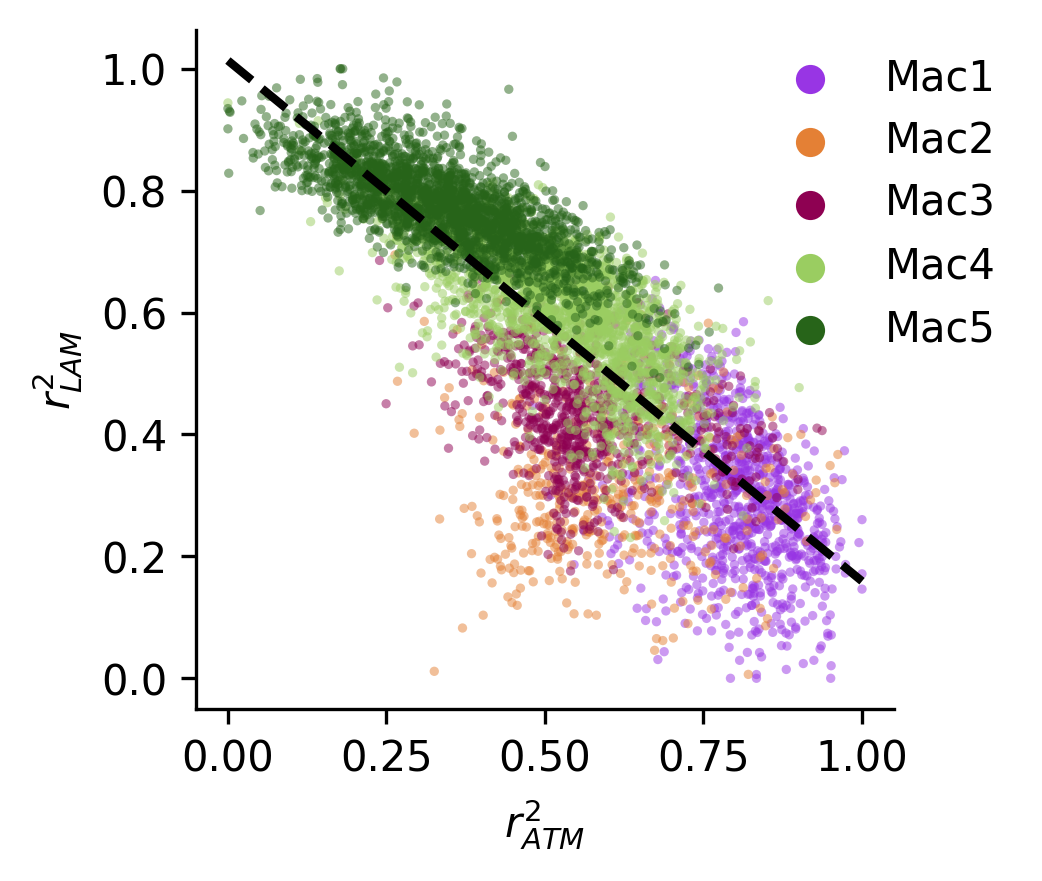

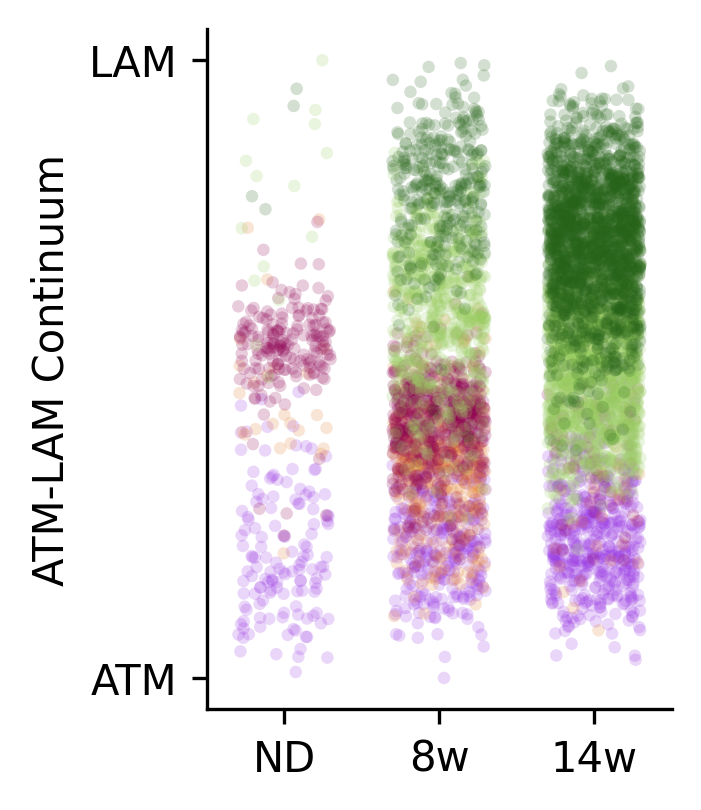

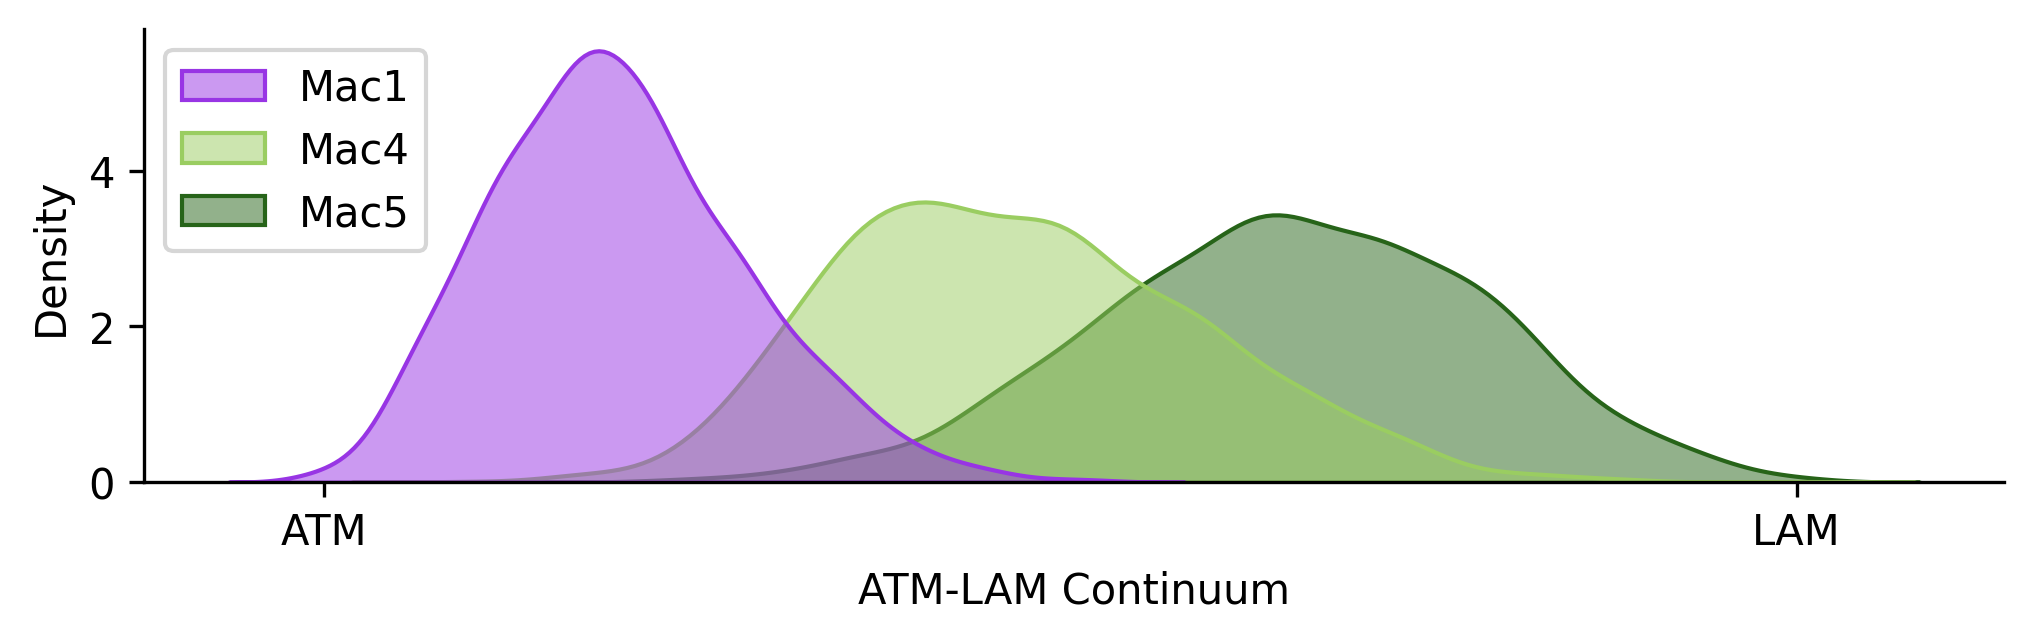

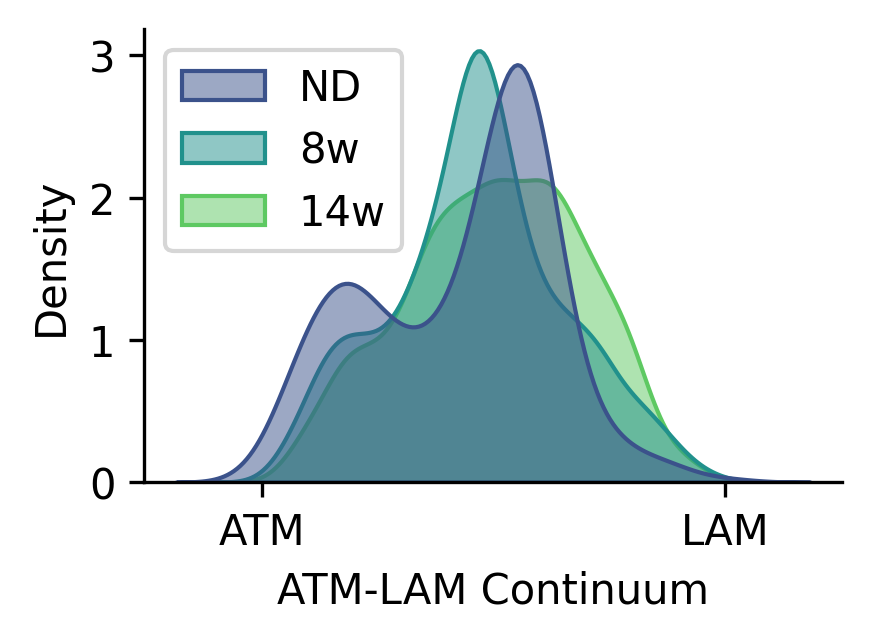

In [34]:
def distanceFromAnchor(df):
    """a function to compute the distance from the upper left-most point"""
    upperLeft = df[df['p2_on_fit'] ==  df['p2_on_fit'].max()]
    upperLeft = upperLeft.sort_values(by='p2', ascending=False)
    upperLeft = upperLeft.head(1)
    
    xMax = upperLeft['p1'].values[0]
    yMax = upperLeft['p2_on_fit'].values[0]
    
    anchor = np.array([xMax, yMax])
    anchor = anchor.reshape((1, len(anchor)))
    
    dists = scipy.spatial.distance.cdist(pdf[['p1', 'p2_on_fit']], 
                                         anchor, 
                                         metric='euclidean')
    
    dists = sklearn.preprocessing.minmax_scale(dists, 
                                               feature_range=(0, 1), 
                                               axis=0)
    return dists

def getProjection(pdf):
    """A function to learn p1/p2 polarization """
    # define variables
    X = pdf['p1'].values[:,np.newaxis]
    y = pdf['p2'].values
    
    # fit the optimal line, get coefficients
    model = linear_model.LinearRegression()
    
    model.fit(X, y)
    m = model.coef_[0]
    b = model.intercept_

    print(f"x = p1, y = p2")
    print(f"{-m:.4f}x + y + {-b:.4f} = 0")
    
    # add predicted values
    fit = model.predict(X)
    pdf['fit'] = fit
    
    # perform macSpectrum porjection
    pdf['xp'] = (pdf['p1'] - (-m*pdf['p2']) - (-m * -b)) / ((-m**2 * -b**2))
    pdf['yp'] = ((-m**2 * pdf['p2']) - (-m * pdf['p1']) - (-b)) / ((-m**2 * -b**2))
    
    # get anchor on p1
    x0 = pdf['p1'].min()
    y0 = pdf['fit'].min()
    # compute macSpectrum distance
    l = np.sqrt((pdf['xp'] - x0)**2 + (pdf['yp'] - y0)**2 )
    pdf['l'] = l
    
    
    # simple projection onto the OLS solution
    p2_on_fit = (np.dot(y, fit)/np.sqrt(sum(fit**2))  **2)*fit
    pdf['p2_on_fit'] = p2_on_fit
    
    return pdf


pdf = res.copy()
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

# get linear projection
pdf = getProjection(pdf)

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=pdf, 
                x='p1',
                y='p2',
                hue='cellType',
                palette=colors,
                s=5,
                alpha=0.5,
                ec='None')

sns.lineplot(data=pdf,
             x='p1',
             y='fit',
             ls="--",
             lw=2,
             color='k')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.2, 1.015),
                frameon=False,
                title="")

plt.ylabel(r"$r^2_{LAM}$")
plt.xlabel(r"$r^2_{ATM}$")

plt.show()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 3
plt.rcParams['figure.facecolor'] = "w"

sns.stripplot(data=pdf, 
                y='xp',
                x='keyName',
                hue='cellType',
                jitter=0.3,
                s=3,
                palette=colors,
                alpha=0.2)

sns.despine()
plt.gca().legend().remove()
# sns.move_legend(plt.gca(), 
#                 bbox_to_anchor=(1.2, 1.014), 
#                 loc='upper right',
#                 title="")

plt.xlabel("")
plt.ylabel("ATM-LAM Continuum")
plt.yticks([pdf['xp'].min(), pdf['xp'].max()], ['LAM', 'ATM'])
plt.gca().invert_yaxis()

plt.show()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 2
plt.rcParams['figure.facecolor'] = "w"

mask = (pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5']))

sns.kdeplot(data=pdf[mask], 
            x='p2_on_fit',
            hue='cellType',
            common_norm=False,
            palette=['#9835e4','#9acd61','#276419'],
            shade=True,
            alpha=0.5)

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper left',
                title="")

plt.ylabel("Density")
plt.xlabel("ATM-LAM Continuum")
plt.xticks([pdf['p2_on_fit'].min(), pdf['p2_on_fit'].max()], ['ATM', 'LAM'])

plt.show()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2
plt.rcParams['figure.facecolor'] = "w"

sns.kdeplot(data=pdf, 
            x='p2_on_fit',
            hue='keyName',
            common_norm=False,
            palette='viridis',
            shade=True,
            alpha=0.5)

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper left',
                title="")

plt.ylabel("Density")
plt.xlabel("ATM-LAM Continuum")
plt.xticks([pdf['p2_on_fit'].min(), pdf['p2_on_fit'].max()], ['ATM', 'LAM'])

plt.show()

In [ ]:
""" Double-check the OLS """
X = np.vstack([pdf['p1'].values, np.ones(len(pdf))]).T
y = pdf['p2']

B = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)
B

# MacSpectrum on Monocytes

In [60]:
mon = []

for key in ['ND', 'HFD8', 'HFD14']:
    mf = getGroup(rna, labels, key, 'Monocytes')
    mon.append(mf)
    
p1 = pd.concat(mon)    
p2 = getGroup(rna, labels, 'HFD14', 'Mac5')

print(f"{p1.shape=} {p2.shape=}")

# get DEGs
deg = getDEGs(p1, p2)
print(f"{deg.shape=}")

# get significant genes
alpha = 0.01
n = 100 # number of genes from each side
# p = 0.01
p = None
corrGenes, sig = getSig(deg, alpha, n, p, method='log2foldchange')
# corrGenes, sig = getSig(deg, alpha, n, p, method='pval')
print(f"{sig.shape=}")

normalize = False
log = True

# define the pole signatures
meanP1 = getSignature(p1, corrGenes, norm=normalize, log=log) # monocytes
meanP2 = getSignature(p2, corrGenes, norm=normalize, log=log) # LAM macrophages

print(f"{meanP1.shape=} {meanP2.shape=}")
print('done')

p1.shape=(1898, 31053) p2.shape=(1870, 31053)
deg.shape=(31053, 8)
alpha=0.01 ntests=31053 3.2365099111864026e-07
sig.shape=(100, 9)
meanP1.shape=(1, 100) meanP2.shape=(1, 100)
done


In [61]:
macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
]

res = []

metric = 'correlation' # note that this is correlation distance (1 - r^2)
# metric = 'euclidean'

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # get correlations to cell type
    rf = rf[corrGenes].astype(float)
    
    if log:
        rf = np.log1p(rf)
    
    if normalize:
        rf[corrGenes] = sklearn.preprocessing.minmax_scale(rf[corrGenes], 
                                                           feature_range=(0, 1), axis=1)
    
    p1Dist = scipy.spatial.distance.cdist(rf, meanP1, metric)
    p2Dist = scipy.spatial.distance.cdist(rf, meanP2, metric)
    
    # normalize distance to range (0, 1)
    p1Dist = sklearn.preprocessing.minmax_scale(p1Dist, feature_range=(0, 1))
    p2Dist = sklearn.preprocessing.minmax_scale(p2Dist, feature_range=(0, 1))
    
    
    pred = pd.DataFrame({
        'p1' : p1Dist.ravel(),
        'p2' : p2Dist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)

res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()

res.shape=(8329, 8)


,p1,p2,cellId,key,cellType,x,y,metaTypes
0,0.680930,0.324148,AAAGAACGTCTACAGT.1,ND,Mac1,3.089298,-1.726030,Macrophages
1,0.758541,0.254436,AAAGAACTCCTCGCAT.1,ND,Mac1,3.614130,-1.571004,Macrophages
2,0.398352,0.780752,AAAGGGCGTTAGGGTG.1,ND,Mac3,3.086352,6.166065,Macrophages
3,0.332178,0.758818,AACAAAGAGTATAGGT.1,ND,Monocytes,3.178745,4.929769,Monocytes
4,0.479872,0.830136,AACAAAGCACCGGCTA.1,ND,Mac3,4.344001,5.801922,Macrophages


x = p1, y = p2
1.1047x + y + -1.1702 = 0


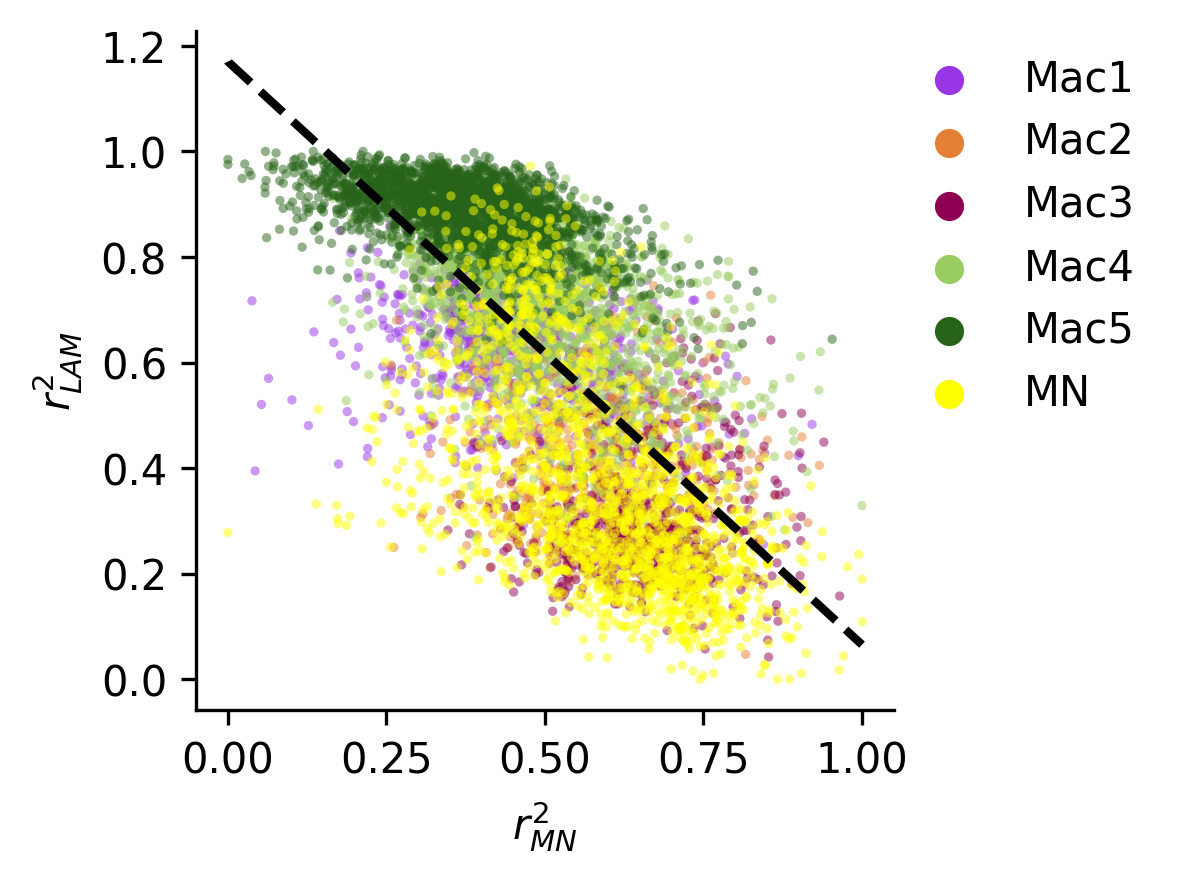

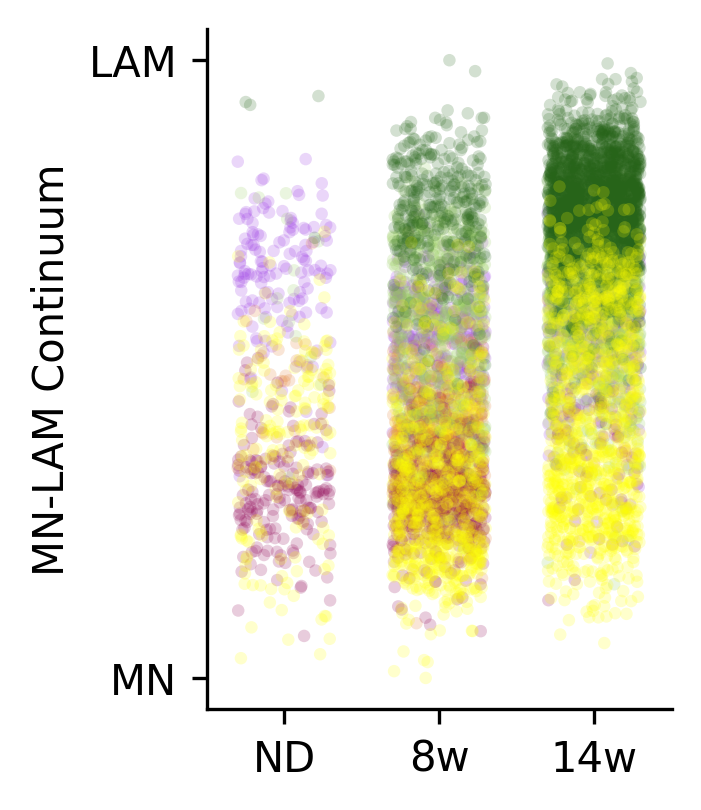

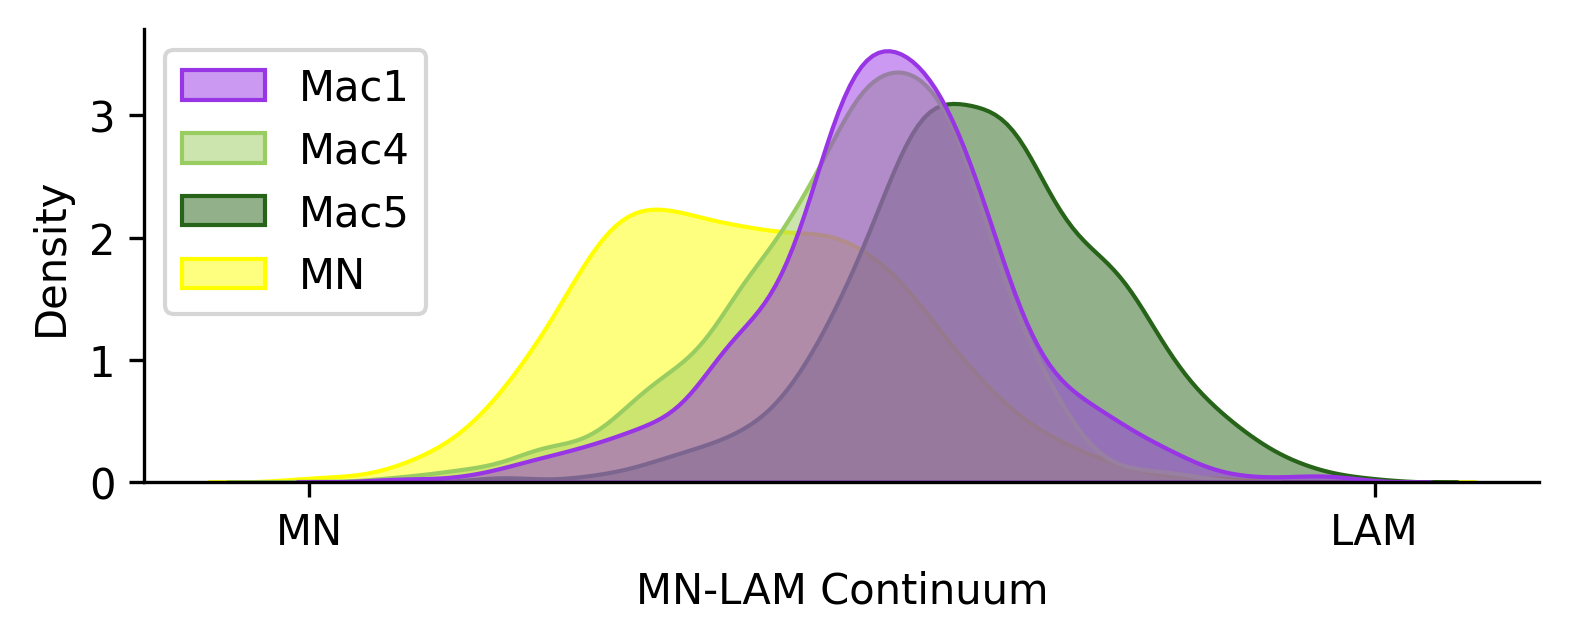

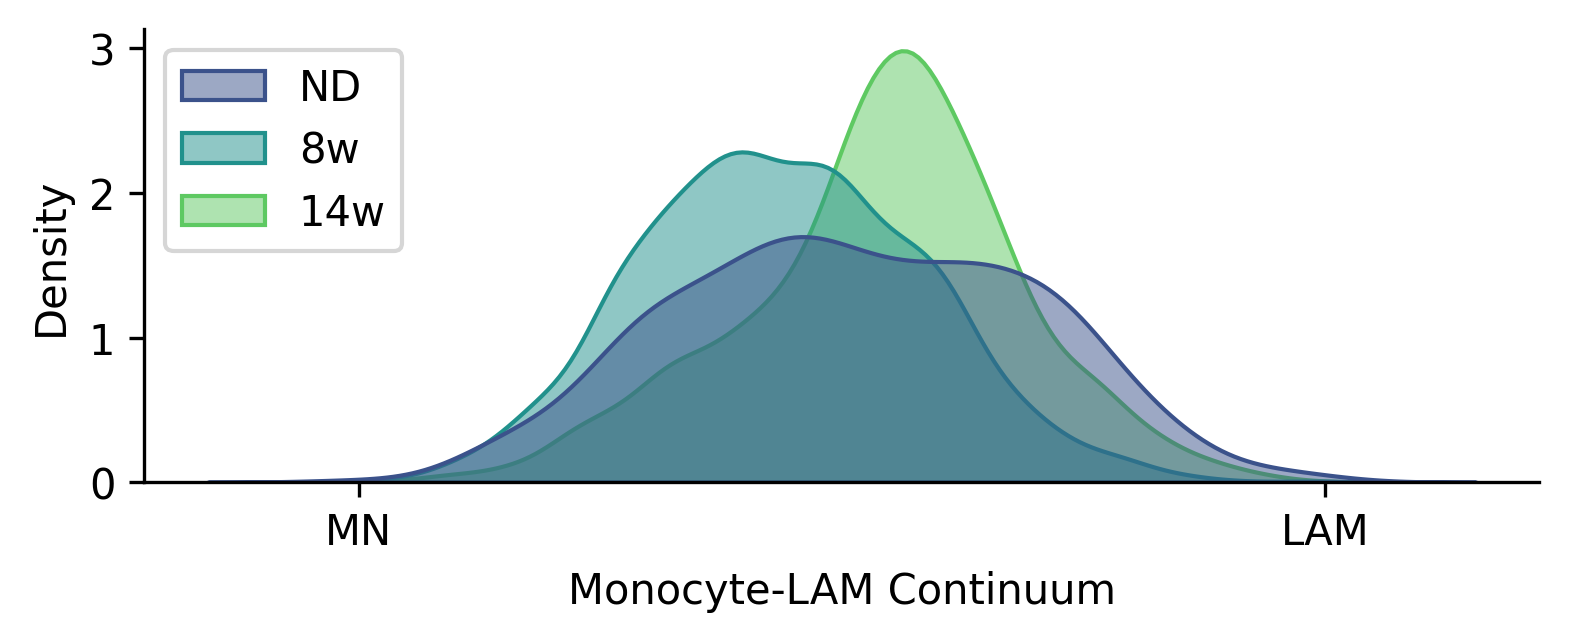

In [62]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

pdf['cellType'] = np.where(pdf['cellType'] == 'Monocytes', "MN", pdf['cellType'])

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

# get linear projection
pdf = getProjection(pdf)
pdf['dists'] = distanceFromAnchor(pdf)

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    'yellow',
]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=pdf, 
                x='p1',
                y='p2',
                hue='cellType',
                palette=colors,
                s=5,
                alpha=0.5,
                ec='None')

sns.lineplot(data=pdf,
             x='p1',
             y='fit',
             ls="--",
             lw=2,
             color='k')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1.015),
                frameon=False,
                title="")

plt.ylabel(r"$r^2_{LAM}$")
plt.xlabel(r"$r^2_{MN}$")

plt.show()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 3
plt.rcParams['figure.facecolor'] = "w"

sns.stripplot(data=pdf, 
                y='xp',
                x='keyName',
                hue='cellType',
                jitter=0.3,
                s=3,
                palette=colors,
                alpha=0.2)

sns.despine()
plt.gca().legend().remove()

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 2
# plt.rcParams['figure.facecolor'] = "w"

# sns.stripplot(data=pdf, 
#                 x='xp',
#                 y='keyName',
#                 hue='cellType',
#                 jitter=0.3,
#                 s=3,
#                 palette=colors,
#                 alpha=0.2)

# sns.despine()
# sns.move_legend(plt.gca(), 
#                 bbox_to_anchor=(1.2, 1.014), 
#                 loc='upper right',
#                 title="")

plt.xlabel("")
plt.ylabel("MN-LAM Continuum")
plt.yticks([pdf['xp'].min(), pdf['xp'].max()], ['LAM', 'MN'])
plt.gca().invert_yaxis()

plt.show()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2
plt.rcParams['figure.facecolor'] = "w"

mask = (pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5', 'MN']))

sns.kdeplot(data=pdf[mask], 
            x='p2_on_fit',
            hue='cellType',
            common_norm=False,
            palette=['#9835e4','#9acd61','#276419', 'yellow'],
            shade=True,
            alpha=0.5)

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper left',
                title="")

plt.ylabel("Density")
plt.xlabel("MN-LAM Continuum")
plt.xticks([pdf['p2_on_fit'].min(), pdf['p2_on_fit'].max()], ['MN', 'LAM'])

plt.show()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2
plt.rcParams['figure.facecolor'] = "w"

sns.kdeplot(data=pdf, 
            x='p2_on_fit',
            hue='keyName',
            common_norm=False,
            palette='viridis',
            shade=True,
            alpha=0.5)

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper left',
                title="")

plt.ylabel("Density")
plt.xlabel("Monocyte-LAM Continuum")
plt.xticks([pdf['p2_on_fit'].min(), pdf['p2_on_fit'].max()], ['MN', 'LAM'])

plt.show()

(array([  29.,  184.,  563., 1482., 2220., 1668., 1269.,  678.,  200.,
          35.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

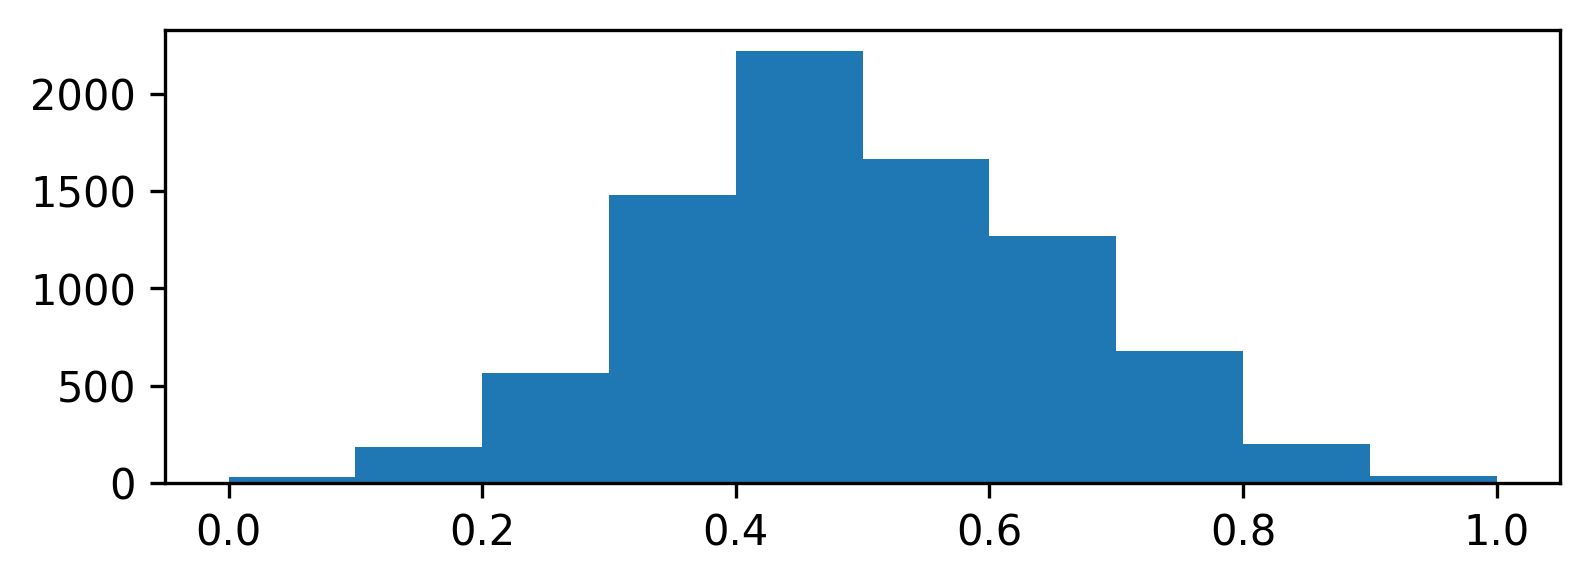

In [93]:
def distanceFromAnchor(df):
    """a function to compute the distance from the upper left-most point"""
    upperLeft = df[df['p2_on_fit'] ==  df['p2_on_fit'].max()]
    upperLeft = upperLeft.sort_values(by='p2', ascending=False)
    upperLeft = upperLeft.head(1)
    
    xMax = upperLeft['p1'].values[0]
    yMax = upperLeft['p2_on_fit'].values[0]
    
    anchor = np.array([xMax, yMax])
    anchor = anchor.reshape((1, len(anchor)))
    
    dists = scipy.spatial.distance.cdist(pdf[['p1', 'p2_on_fit']], 
                                         anchor, 
                                         metric='euclidean')
    
    dists = sklearn.preprocessing.minmax_scale(dists, 
                                               feature_range=(0, 1), 
                                               axis=0)
    
    
    
    
    return dists
    

pdf['dists'] = distanceFromAnchor(pdf)
plt.hist(pdf['dists'])

In [71]:
pdf[pdf['p2_on_fit'] ==  pdf['p2_on_fit'].max()][['p1', 'p2_on_fit']].head(1)

,p1,p2_on_fit
2710,0.0,1.1702


<AxesSubplot: xlabel='p1', ylabel='p2_on_fit'>

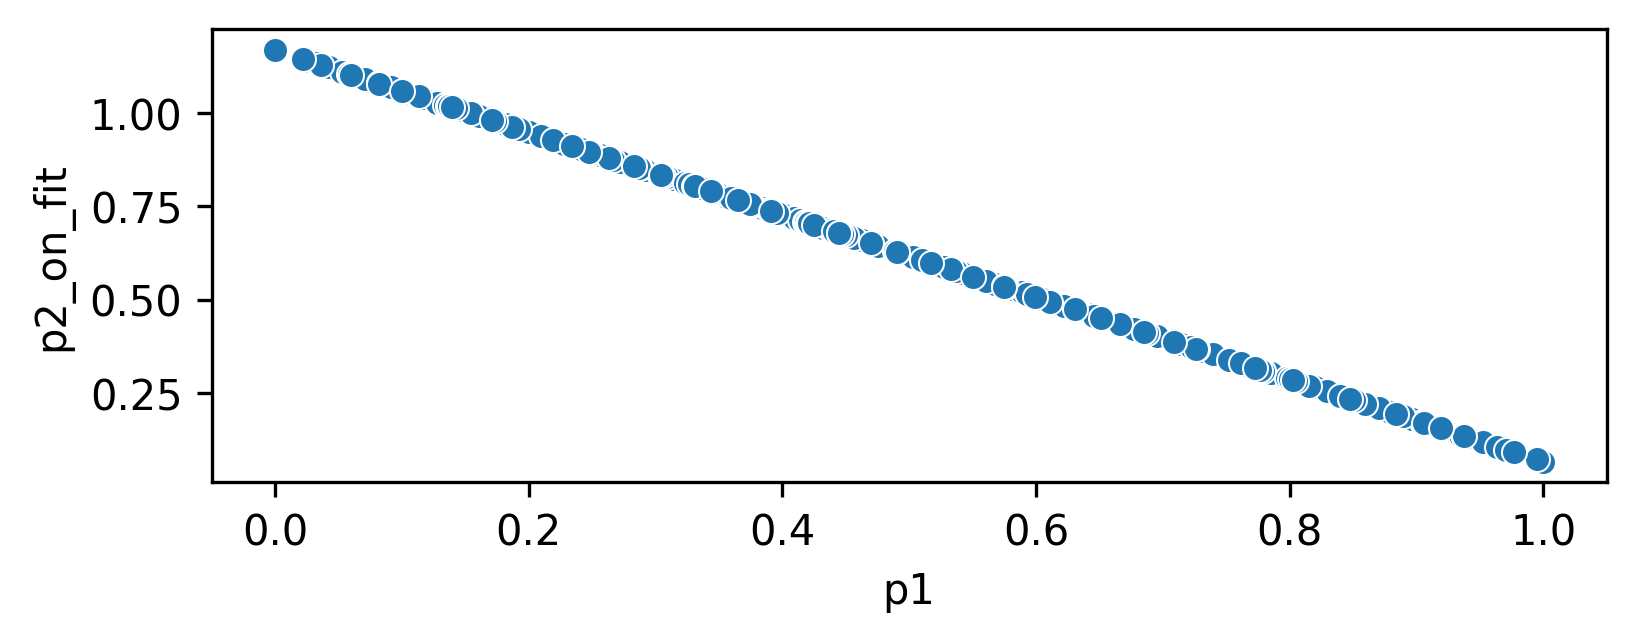

In [64]:
sns.scatterplot(data=pdf,
                x='p1',
                y='p2_on_fit',
)

In [ ]:
print(pdf[['p1', 'p2']].min())
print(pdf[['p1', 'p2']].max())

In [ ]:
# break

# A classification approach

In [ ]:
df = pd.concat([atm, lam])
print(f"{df.shape}")
X = df.to_numpy()

print(f"{X.shape=}")

y = np.array(([-1] * atm.shape[0]) + ([1] * lam.shape[0]))
print(f"{y.shape=}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# clf = linear_model.Lasso(alpha=0.075)
clf = sklearn.linear_model.LogisticRegression(penalty='l1',
                                              solver='liblinear',
                                              # class_weight='balanced',
                                              C=2)

# clf = linear_model.Lasso(alpha=0.001)
# clf = RandomForestClassifier(max_depth=10,
#                              criterion='entropy',
#                              max_features=500)

# quick evaluation
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

auc = metrics.roc_auc_score(y_test, y_proba[:, 1])

print(f"Testing {auc=}")
print(metrics.classification_report(y_test, y_pred, target_names=['ATM', 'LAM']))


In [ ]:
# # # get genes with positive coefficients
# positiveGenes = list(atm.columns[np.argwhere(clf.coef_ > 0)].flatten())
# print(len(positiveGenes))

# positiveGenes[:10]

In [ ]:
break

In [ ]:
# # get genes with positive coefficients
# positiveGenes = list(atm.columns[np.argwhere(clf.coef_ > 0)].flatten())
# print(len(positiveGenes))


# X = df[positiveGenes]
# print(X.shape)

# # compute the PCA 
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(X)
# colors = list((["C0"] * atm.shape[0]) + (["C3"] * lam.shape[0]))

# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     c=colors,
#     s=15,
#     alpha=0.8,
#     ec='k',
# )

In [ ]:
macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

# # get genes with positive coefficients
# positiveGenes = atm.columns[np.argwhere(clf.coef_ > 0)].flatten()
# positiveGenes = sorted(positiveGenes)
# print(len(positiveGenes))

# get the agg expression profile for both poles
# meanAtm = atm[positiveGenes].mean(axis=0).to_numpy()
meanAtm = atm.mean(axis=0).to_numpy()
meanAtm = meanAtm.reshape((1, len(meanAtm))) 
meanAtm = meanAtm.astype(float)

# meanLam = lam[positiveGenes].mean(axis=0).to_numpy()
meanLam = lam.mean(axis=0).to_numpy()
meanLam = meanLam.reshape((1, len(meanLam))) 
meanLam = meanLam.astype(float)

metric = 'correlation'

res = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    X = rf.to_numpy()
    
    # get polarization prediction
    # pred = clf.predict(X)
    pred = clf.predict_proba(X)[:, 0] # get the probability of -1 pol classification
    print(pred.shape)
    
    # get correlations to cell type
    # rf = rf[positiveGenes]
    atmDist = scipy.spatial.distance.cdist(rf, meanAtm, metric)
    lamDist = scipy.spatial.distance.cdist(rf, meanLam, metric)
    
    
    pred = pd.DataFrame({
        'pol' : pred,
        'atm' : atmDist.ravel(),
        'lam' : lamDist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)

res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()

In [ ]:
pdf = res.copy()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
plt.rcParams['figure.facecolor'] = "w"

q = 0.05
lb = np.percentile(pdf['pol'], q)
up = np.percentile(pdf['pol'], 100-q)
pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]

sns.scatterplot(data=pdf, 
                x='x',
                y='y',
                hue='pol',
                linewidths=0.5,
                alpha=0.75,
                s=5,
                ec='k',
                palette=plt.cm.get_cmap('RdYlGn', lut=10))

In [ ]:
pdf = res.copy()
# q = 0.05
# lb = np.percentile(pdf['pol'], q)
# up = np.percentile(pdf['pol'], 100-q)
# pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]

# restructure polarization
pdf['pol'] = 1 - pdf['pol']

# convert distances to correlations
pdf['atm'] = 1 - pdf['atm']
pdf['lam'] = 1 - pdf['lam']

pdf = pdf.sort_values(by='cellType')

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()

sns.scatterplot(data=pdf,
                x='pol',
                y='atm',
                hue='cellType',
                palette=colors,
                s=5,
                ec='k',
                legend=False,
                ax=axs[0])

axs[0].set_xticks([0, 1])
axs[0].set_ylim([0, 1])
axs[0].set_xticklabels(['ATM', 'LAM'])
axs[0].set_ylabel("Correlation with ATM")
axs[0].set_xlabel("")

sns.scatterplot(data=pdf,
                x='pol',
                y='lam',
                hue='cellType',
                palette=colors,
                s=5,
                ec='k',
                ax=axs[1])

axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['ATM', 'LAM'])
axs[1].set_ylabel("Correlation with LAM")
axs[1].set_xlabel("")

plt.legend(bbox_to_anchor=(1.4, 1.4), ncol=5)
plt.tight_layout()

In [ ]:
break

In [ ]:
pdf = res.copy()
# q = 0.05
# lb = np.percentile(pdf['pol'], q)
# up = np.percentile(pdf['pol'], 100-q)
# pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]

# restructure polarization
pdf['pol'] = 1 - pdf['pol']

# convert distances to correlations
pdf['atm'] = 1 - pdf['atm']
pdf['lam'] = 1 - pdf['lam']

pdf = pdf.sort_values(by='key', ascending=False)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()

sns.scatterplot(data=pdf,
                x='pol',
                y='atm',
                hue='key',
                palette='viridis',
                s=5,
                ec='k',
                legend=False,
                ax=axs[0])

axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['ATM', 'LAM'])
axs[0].set_ylabel("Correlation with ATM")
axs[0].set_xlabel("")

sns.scatterplot(data=pdf,
                x='pol',
                y='lam',
                hue='key',
                palette='viridis',
                s=5,
                ec='k',
                ax=axs[1])

axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['ATM', 'LAM'])
axs[1].set_ylabel("Correlation with LAM")
axs[1].set_xlabel("")

plt.legend(bbox_to_anchor=(1.4, 1.4))
plt.tight_layout()

In [ ]:
# pdf = res.copy()

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 4, 4
# plt.rcParams['figure.facecolor'] = "w"

# sns.scatterplot(data=pdf, 
#                 x='x',
#                 y='y',
#                 hue='lam',
#                 linewidths=0.5,
#                 alpha=0.75,
#                 s=5,
#                 ec='k',
#                 palette=plt.cm.get_cmap('RdYlGn', lut=10))

In [ ]:
break

In [ ]:
pdf = res.copy()

# q = 0.05
# lb = np.percentile(pdf['pol'], q)
# up = np.percentile(pdf['pol'], 100-q)

# pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]

# restructure polarization
pdf['pol'] = 1 - pdf['pol']

pdf = pdf[pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5'])]
print(lb, up)


scaler = MinMaxScaler(feature_range=(-1, 1))
pdf['polNorm'] = scaler.fit_transform(pdf['pol'].to_numpy().reshape(-1, 1))


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.5, 1.25
plt.rcParams['figure.facecolor'] = "w"

sns.kdeplot(data=pdf, 
             x='polNorm',
             common_norm=False,
             hue='key',
             fill=True,
             zorder=3,
             palette='viridis')

plt.axvline(x=0, zorder=0, c='grey', ls="--")

# plt.yscale('log')

plt.xlabel('')
# plt.yticks([])
plt.xticks([-1, 1], ['ATM', 'LAM'])

ax = plt.gca()
ax.legend().remove()
ax.set_ylabel('Density')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
sns.despine(right=False, left=True)

In [ ]:
# break

In [ ]:
pdf = res.copy()

# q = 0.05
# lb = np.percentile(pdf['pol'], q)
# up = np.percentile(pdf['pol'], 100-q)

# pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]


# restructure polarization
pdf['pol'] = 1 - pdf['pol']

pdf = pdf.sort_values(by='cellType')
pdf = pdf[pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5'])]

colors = [
    '#9835e4',
    # '#e48035',
    # '#8e0152',
    '#9acd61',
    '#276419',
]

g = sns.FacetGrid(pdf, 
                  row="cellType", 
                  hue="cellType", 
                  height=0.8, 
                  aspect=4,
                  sharey = False,
                  # gridspec_kws={"hspace":-1},
                  palette=colors)

# Draw the densities in a few steps
g.map(sns.kdeplot, "pol",
      # bw_adjust=.5, 
      # clip_on=True,
      fill=True, 
      alpha=0.8, 
      linewidth=1.5)

g.map(sns.kdeplot, "pol", 
      # clip_on=True, 
      common_norm=False,
      color="k", 
      lw=1)

g.set_titles("")

g.set(
        # yticks=[],
      # ylim=[0, 0.5],
      ylabel="",
      xlabel="",
      xticks=[0, 1],
      xticklabels=["ATM", "LAM"])

g.despine(bottom=False, left=True, right=False)

ylims = [
    [0, 4],
    [0, 18],
    [0, 30],
]

for i, (ax, label) in enumerate(zip(g.axes.flat, pdf['cellType'].unique())):
    ax.text(0, 0.3, label, 
            # fontweight="bold", 
            # color=color,
            ha="left", 
            va="center", 
            transform=ax.transAxes)
    
    ax.set_ylim(ylims[i])
    ax.yaxis.tick_right()
    
    if i == 1:
        ax.set_ylabel('Density')
        ax.yaxis.set_label_position("right")
    
plt.subplots_adjust(hspace=0.1)

# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
# plt.xlabel('Mean Expression')


In [ ]:
break

# Monocytes

In [ ]:
mon = []

for key in keys:
    
    mf = getGroup(rna, labels, key, 'Monocytes')
    mon.append(mf)
    
mon = pd.concat(mon)
    
lam = getGroup(rna, labels, 'HFD14', 'Mac5')
print(mon.shape, lam.shape)

df = pd.concat([mon, lam])
print(f"{df.shape}")
X = df.to_numpy()

print(f"{X.shape=}")

y = np.array(([-1] * mon.shape[0]) + ([1] * lam.shape[0]))
print(f"{y.shape=}")

# clf = linear_model.Lasso(alpha=0.2)

clf = RandomForestClassifier(max_depth=10,
                             criterion='entropy',
                             max_features=500)

clf.fit(X, y)
clf.score(X, y)

In [ ]:
# break

In [ ]:
# get genes with positive coefficients
# positiveGenes = mon.columns[np.argwhere(clf.coef_ > 0)].flatten()
# positiveGenes = sorted(positiveGenes)
# print(len(positiveGenes))

# get the agg expression profile for both poles
# meanMon = mon[positiveGenes].mean(axis=0).to_numpy()
meanMon = mon.mean(axis=0).to_numpy()
meanMon = meanMon.reshape((1, len(meanMon))) 
meanMon = meanMon.astype(float)

# meanLam = lam[positiveGenes].mean(axis=0).to_numpy()
meanLam = lam.mean(axis=0).to_numpy()
meanLam = meanLam.reshape((1, len(meanLam))) 
meanLam = meanLam.astype(float)


macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
]

res = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]

    X = rf.to_numpy()
    
    # get polarization prediction
    # pred = clf.predict(X)
    pred = clf.predict_proba(X)[:, 0]
    
    # get correlations to cell type
    # rf = rf[positiveGenes]
    monDist = scipy.spatial.distance.cdist(rf, meanMon, metric)
    lamDist = scipy.spatial.distance.cdist(rf, meanLam, metric)
    
    
    pred = pd.DataFrame({
        'pol' : pred,
        'mon' : monDist.ravel(),
        'lam' : lamDist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)
    
res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()

In [ ]:
pdf = res.copy()
# q = 0.8
# lb = np.percentile(pdf['pol'], q)
# up = np.percentile(pdf['pol'], 100-q)
# pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]

print(pdf['pol'].min())
print(pdf['pol'].max())

# restructure polarization
pdf['pol'] = 1 - pdf['pol']

# convert distances to correlations
pdf['mon'] = 1 - pdf['mon']
pdf['lam'] = 1 - pdf['lam']

pdf = pdf.sort_values(by='cellType')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    'yellow',
]

sns.scatterplot(data=pdf,
                x='pol',
                y='mon',
                hue='cellType',
                palette=colors,
                s=5,
                ec='k',
                legend=False,
                ax=axs[0])

axs[0].set_xticks([-1, 1])
# axs[0].set_xlim([-1.1, 1.1])
axs[0].set_ylim([0.4, 1])
axs[0].set_xticklabels(['MN', 'LAM'])
axs[0].set_ylabel("Correlation with MN")
axs[0].set_xlabel("")

sns.scatterplot(data=pdf,
                x='pol',
                y='lam',
                hue='cellType',
                palette=colors,
                s=5,
                ec='k',
                ax=axs[1])

axs[1].set_xticks([-1, 1])
axs[1].set_xticklabels(['MN', 'LAM'])
axs[1].set_ylabel("Correlation with LAM")
axs[1].set_xlabel("")

# plt.legend(bbox_to_anchor=(1.4, 1.4), ncol=6)
plt.tight_layout()

In [ ]:
break

In [ ]:
pdf = res.copy()
q = 0.8
lb = np.percentile(pdf['pol'], q)
up = np.percentile(pdf['pol'], 100-q)
pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]

print(pdf['pol'].min())
print(pdf['pol'].max())

# convert distances to correlations
pdf['mon'] = 1 - pdf['mon']
pdf['lam'] = 1 - pdf['lam']

pdf = pdf.sort_values(by='cellType')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    'yellow',
]

sns.scatterplot(data=pdf,
                x='pol',
                y='mon',
                hue='key',
                palette='viridis',
                s=5,
                ec='k',
                legend=False,
                ax=axs[0])

axs[0].set_xticks([-1, 1])
# axs[0].set_xlim([-1.1, 1.1])
axs[0].set_ylim([0.4, 1])
axs[0].set_xticklabels(['MN', 'LAM'])
axs[0].set_ylabel("Correlation with MN")
axs[0].set_xlabel("")

sns.scatterplot(data=pdf,
                x='pol',
                y='lam',
                hue='key',
                palette='viridis',
                s=5,
                ec='k',
                ax=axs[1])

axs[1].set_xticks([-1, 1])
axs[1].set_xticklabels(['MN', 'LAM'])
axs[1].set_ylabel("Correlation with LAM")
axs[1].set_xlabel("")

plt.legend(bbox_to_anchor=(1.4, 1.4))
plt.tight_layout()

In [ ]:
pdf = res.copy()

q = 0.2
lb = np.percentile(pdf['pol'], q)
up = np.percentile(pdf['pol'], 100-q)

pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]

pdf = pdf[pdf['cellType'].isin(['Monocytes', 'Mac4', 'Mac5'])]
print(lb, up)


scaler = MinMaxScaler(feature_range=(-1, 1))
pdf['polNorm'] = scaler.fit_transform(pdf['pol'].to_numpy().reshape(-1, 1))


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 1.25
plt.rcParams['figure.facecolor'] = "w"

sns.kdeplot(data=pdf, 
             x='polNorm',
             common_norm=False,
             hue='key',
             fill=True,
             zorder=3,
             palette='viridis')

plt.axvline(x=0, zorder=0, c='grey', ls="--")

# plt.yscale('log')

plt.xlabel('')
# plt.yticks([])
plt.xticks([-.6, .6], ['MN', 'LAM'])

ax = plt.gca()
ax.legend().remove()
ax.set_ylabel('Density')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
sns.despine(right=False, left=True)

In [ ]:
pdf = res.copy()

q = 0.05
lb = np.percentile(pdf['pol'], q)
up = np.percentile(pdf['pol'], 100-q)

pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]
pdf = pdf.sort_values(by='key', ascending=False)
pdf = pdf[pdf['cellType'].isin(['Monocytes', 'Mac4', 'Mac5'])]

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    'yellow',
]

g = sns.FacetGrid(pdf, 
                  row="key", 
                  hue="key", 
                  height=0.8, 
                  aspect=4,
                  sharey = False,
                  # gridspec_kws={"hspace":-1},
                  palette='viridis')

# Draw the densities in a few steps
g.map(sns.kdeplot, "pol",
      # bw_adjust=.5, 
      # clip_on=True,
      fill=True, 
      alpha=0.8, 
      linewidth=1.5)

g.map(sns.kdeplot, "pol", 
      # clip_on=True, 
      color="k", 
      lw=1)

g.set_titles("")

g.set(
      # yticks=[],
      # ylim=[0, 4],
      ylabel="",
      xlabel="",
      xticks=[-1, 1],
      xticklabels=["MN", "LAM"])

g.despine(bottom=False, left=True, right=False)

for i,(ax, label) in enumerate(zip(g.axes.flat, pdf['key'].unique())):
    ax.text(0, 0.3, label, 
            # fontweight="bold", 
            # color=color,
            ha="left", 
            va="center", 
            transform=ax.transAxes)
    
    if i == 1:
        ax.set_ylabel('Density')
        ax.yaxis.set_label_position("right")

# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
# plt.xlabel('Mean Expression')


In [ ]:
pdf = res.copy()

q = 0.05
lb = np.percentile(pdf['pol'], q)
up = np.percentile(pdf['pol'], 100-q)

pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]
pdf = pdf.sort_values(by='cellType')
pdf = pdf[pdf['cellType'].isin(['Monocytes', 'Mac4', 'Mac5'])]

colors = [
    # '#9835e4',
    # '#e48035',
    # '#8e0152',
    '#9acd61',
    '#276419',
    'yellow',
]

g = sns.FacetGrid(pdf, 
                  row="cellType", 
                  hue="cellType", 
                  height=1, 
                  aspect=4,
                  sharey=False,
                  palette=colors)

# Draw the densities in a few steps
g.map(sns.kdeplot, "pol",
      # bw_adjust=.5, 
      # clip_on=True,
      fill=True, 
      alpha=0.8, 
      linewidth=1.5)

g.map(sns.kdeplot, "pol", 
      # clip_on=True, 
      color="k", 
      lw=1)

g.set_titles("")

g.set(
      # yticks=[],
      # ylim=[0, 4],
      ylabel="",
      xlabel="",
      xticks=[-1, 1],
      xticklabels=["MN", "LAM"])

g.despine(bottom=False, left=True, right=False,)

for i, (ax, label) in enumerate(zip(g.axes.flat, pdf['cellType'].unique())):
    
    
    ax.text(0, 0.6, label, 
            # fontweight="bold", 
            # color=color,
            ha="left", 
            va="center", 
            transform=ax.transAxes)
    

# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
# plt.xlabel('Mean Expression')

# fig = plt.gcf()
# fig.supylabel('Density')
# fig.yaxis.set_label_position("right")


In [ ]:
pdf = res.copy()

q = 0.05
lb = np.percentile(pdf['pol'], q)
up = np.percentile(pdf['pol'], 100-q)

pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]
pdf = pdf.sort_values(by='key', ascending=False)
pdf = pdf[pdf['cellType'].isin(['Monocytes', 'Mac4', 'Mac5'])]

g = sns.FacetGrid(pdf, 
                  row="cellType", 
                  hue="key", 
                  height=1, 
                  aspect=4,
                  # gridspec_kws={"hspace":-1},
                  palette='viridis')

# Draw the densities in a few steps
g.map(sns.kdeplot, "pol",
      # bw_adjust=.5, 
      # clip_on=True,
      fill=True, 
      alpha=0.8, 
      linewidth=1.5)

g.map(sns.kdeplot, "pol", 
      # clip_on=True, 
      color="k", 
      lw=1)

g.set_titles("")

g.set(yticks=[],
      # ylim=[0, 4],
      ylabel="",
      xlabel="",
      xticks=[-1, 1],
      xticklabels=["MON", "LAM"])

g.despine(bottom=False, left=True)

for ax, label in zip(g.axes.flat, pdf['cellType'].unique()):
    ax.text(0, 1, label, 
            # fontweight="bold", 
            # color=color,
            ha="left", 
            va="center", 
            transform=ax.transAxes)

# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
# plt.xlabel('Mean Expression')


In [ ]:
break

In [ ]:
# pdf = res.copy()
# outpath = "~/temp/macpolarization.csv"
# pdf.to_csv(outpath, index=False)
# pdf.head()

In [ ]:
pdf = res.copy()

q = 0.05
lb = np.percentile(pdf['pol'], q)
up = np.percentile(pdf['pol'], 100-q)

pdf = pdf[(pdf['pol'] > lb) & (pdf['pol'] < up)]
print(lb, up)


scaler = MinMaxScaler(feature_range=(-1, 1))
pdf['polNorm'] = scaler.fit_transform(pdf['pol'].to_numpy().reshape(-1, 1))


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 1.5
plt.rcParams['figure.facecolor'] = "w"


sns.histplot(data=pdf, 
             bins=100, 
             stat='frequency',
             x='polNorm',
             hue='cellType',
             fill=True,
             zorder=3,
             palette='Spectral')

plt.axvline(x=0, zorder=0, c='grey', ls="--")

plt.yscale('log')
plt.xlabel('')
plt.xticks([-1, 1], ['ATM', 'LAM'])
ax = plt.gca().legend().remove()
sns.despine()

In [ ]:
len(rf.index.to_list())

In [ ]:
len(lf)

In [ ]:
clf.coef_.shape

In [ ]:
y_pred = clf.predict_proba(X)
print(y_pred.shape)

In [ ]:
y_pred = clf.predict(X)
plt.scatter(y_pred, y)

In [ ]:
print(y_pred.max())
print(y_pred.min())

In [ ]:
y_pred[:10]

In [ ]:
# atm.columns[np.argwhere(clf.coef_ > 0)]

In [ ]:

# df = pd.concat([atm, lam])
# print(f"{df.shape}")
# X = df.to_numpy()

# # compute the PCA 
# k = 15
# pca = PCA(n_components=k)
# pcaModel = pca.fit(X)
# Xpca = pca.fit_transform(X)

# print(Xpca.shape)

In [ ]:
break

In [ ]:
atmSig = pca.transform(atm.mean())

In [ ]:
t = 0.2

atm = getGroup(rna, labels, 'ND', 'Mac1')
lam = getGroup(rna, labels, 'HFD14', 'Mac5')
print(atm.shape, lam.shape)

# extract genes expressed by at least t percent of the target population
atmc = atm.astype(bool).sum(axis=0)
atmc = atmc / len(atm)
atmg = atmc[atmc > t].index.to_list()

lamc = lam.astype(bool).sum(axis=0)
lamc = lamc / len(lam)
lamg = lamc[lamc > t].index.to_list()


allgenes = list(set(atmg + lamg))
print(f"{len(atmg)=} {len(lamg)=} {len(allgenes)=}")


deg = []


for g in allgenes:
    score, pval = scipy.stats.ranksums(atm[g], lam[g],
                               alternative='two-sided')
    
    lfc = np.log2(atm[g].mean()+1) - np.log2(lam[g].mean()+1)
    
    row = {
        'gene' : g,
        'score' : score,
        'pval' : pval,
        'log2foldchange' : lfc,
        'meanATM' : atm[g].mean(),
        'meanLAM' : lam[g].mean(),
    }
    
    deg.append(row)
    
    
deg = pd.DataFrame(deg)
print(f"{deg.shape}")
deg.head()

In [ ]:
alpha = 0.01
lft = 0.5

sig = deg[deg['pval'] < alpha]
sig = sig[sig['log2foldchange'].abs() > lft]

print(f"{sig.shape=}")

atmGenes = sig[sig['log2foldchange'] > 0]['gene'].to_list()
lamGenes = sig[sig['log2foldchange'] < 0]['gene'].to_list()

print(f"{len(atmGenes)=} {len(lamGenes)=}")

refs = {
    'ATM' : atm[atmGenes].mean(axis=0),
    'LAM' : lam[lamGenes].mean(axis=0),
}

print('done')


In [ ]:
macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

metric = 'jensenshannon'

res = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    for mtype, signature in refs.items():
        
        x = rf[signature.index].astype(float)
        y = signature.to_numpy().reshape((1, len(signature))).astype(float)
        print(x.shape, y.shape)
        
        dist = pd.DataFrame(scipy.spatial.distance.cdist(x, y, metric), columns=['d'])
            
        dist['d'] = (dist['d'] - np.min(dist['d']))/np.ptp(dist['d']) # normalize distances
        
        dist['cellId'] = x.index
        dist['key'] = key
        dist['mtype'] = mtype

        dist = pd.merge(dist, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
        res.append(dist)
               
res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
pdf = res.copy()

pdf = pd.pivot_table(pdf, 
                     index=['cellId', 'key', 'cellType'],
                     columns=['mtype'],
                     values=['d']).reset_index()

pdf.columns = ["".join(x) for x in pdf.columns]
pdf = pdf.sort_values(by='cellType')
pdf['dATM'] = 1 - pdf['dATM']
pdf['dLAM'] = 1 - pdf['dLAM']

pdf = pdf[pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5'])]
pdf.head()


colors = [
    '#9835e4',
    # '#e48035',
    # '#8e0152',
    '#9acd61',
    '#276419',
]

sns.scatterplot(data=pdf, 
                x='dATM',
                y='dLAM', 
                s=3,
                ec='k',
                hue='cellType',
                palette=colors)


# group by means
grped = pdf.groupby('cellType').agg(
 lam = ('dLAM', np.median),
 atm = ('dATM', np.median)
).reset_index()

sns.scatterplot(data=grped, 
                x='atm',
                y='lam',
                s=50,
                ec='k',
                legend=False,
                palette=colors,
                # palette='Set1',
                zorder=4,
                hue='cellType',
                alpha=1)

plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.3))

grped

# coefficients = np.polyfit(grped['lam'],grped['atm'], 3)
# polynomial = np.poly1d(coefficients)
# y_axis = np.linspace(0,1,100)
# x_axis = polynomial(x_axis)
# plt.plot(x_axis, y_axis, c='r')

# sns.despine()

# # Print the findings
# print('a =', coefficients[0])
# print('b =', coefficients[1])

# # Let's compute the values of the line...
# polynomial = np.poly1d(coefficients)
# x_axis = np.linspace(0,1,100)
# y_axis = polynomial(x_axis)

# plt.plot(x_axis, y_axis, c='r')
# sns.despine()

# pdf.head()

In [ ]:
pdf = res.copy()

pdf = pd.pivot_table(pdf, 
                     index=['cellId', 'key', 'cellType'],
                     columns=['mtype'],
                     values=['d']).reset_index()

pdf.columns = ["".join(x) for x in pdf.columns]
pdf = pdf.sort_values(by='cellType')
pdf['dATM'] = 1 - pdf['dATM']
pdf['dLAM'] = 1 - pdf['dLAM']

keyMap = {
    'ND' : "ND", 
    'HFD8' : "8w",
    'HFD14' : "14w",
}

pdf['label'] = pdf['key'].map(keyMap)

mask = pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5'])
pdf = pdf[mask]


colors = [
    '#9835e4',
    # '#e48035',
    # '#8e0152',
    '#9acd61',
    '#276419',
]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"


# group by means
grped = pdf.groupby('cellType').agg(
 lam = ('dLAM', np.median),
 atm = ('dATM', np.median)
).reset_index()

sns.scatterplot(data=grped, 
                x='atm',
                y='lam',
                s=50,
                ec='k',
                legend=False,
                palette=colors,
                # palette='Set1',
                zorder=4,
                hue='cellType',
                alpha=1)

sns.scatterplot(data=pdf, 
                x='dATM',
                y='dLAM',
                s=3,
                ec='k',
                palette=colors,
                # palette='Set1',
                alpha=0.8, 
                hue='cellType')

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
# plt.gca().invert_xaxis()
plt.ylabel("LAM")
plt.xlabel("ATM")
plt.xlim([0, 1])
plt.ylim([0, 1])

coefficients = np.polyfit(grped['lam'],grped['atm'], 1)

# Print the findings
print('a =', coefficients[0])
print('b =', coefficients[1])

# Let's compute the values of the line...
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(0,1,100)
y_axis = polynomial(x_axis)

plt.plot(x_axis, y_axis, c='r')
sns.despine()

In [ ]:
grped

In [ ]:
# pos = sig[sig['log2foldchange'] > 0]
# pos = pos.sort_values(by='log2foldchange')
# pos.head(30)

In [ ]:
# n = 100
# ef = gget.enrichr(pos['gene'].head(n).to_list(), 
#              database='GO_Biological_Process_2021')

# ef.head(10)

In [ ]:
# neg = sig[sig['log2foldchange'] < 0]
# neg = neg.sort_values(by='log2foldchange', ascending=True)
# neg.head(30)

In [ ]:
# n = 100
# ef = gget.enrichr(neg['gene'].head(n).to_list(), 
#              database='GO_Biological_Process_2021')

# ef.head(10)

In [ ]:
# get all genes
allgenes = list(set(ref['gene'].to_list()))


pathways = {    
    "04210" :  "Apoptosis",
    "04110" :  "Cell cycle",
}

pwayGenes = {
    # "all" : allgenes,
}

for pid, pname in pathways.items():
    pidFull = f"mmu{pid}"
    g = ut.parseKEGG(pidFull)
    g = [x.upper() for x in g if x.upper() in allgenes] # force expressed
    g = sorted(g)
    print(f"{pname=} {len(g)}")
    pwayGenes[pname] = g

print('done')

In [ ]:
macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

metric = 'correlation'

res = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    for pway, genes in pwayGenes.items():
        x = rf[genes].astype(float)
    

        for mtype in ['atm', 'lam']:
            print(f"{key=} {pway=} {mtype=}")

            y = ref[ref['gene'].isin(genes)].sort_values(by='gene')[mtype].to_numpy()
            y = y.reshape((1, len(y))) 
            y = y.astype(float)
            
            rf2 = pd.DataFrame(scipy.spatial.distance.cdist(x, y, metric), columns=['d'])
            
            rf2['d'] = (rf2['d'] - np.min(rf2['d']))/np.ptp(rf2['d']) # normalize distances
            
            rf2['cellId'] = x.index
            rf2['key'] = key
            rf2['mtype'] = mtype
            rf2['pway'] = pway
            
            rf2 = pd.merge(rf2, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                           how='left', 
                           right_on='cellId',
                           left_on='cellId')
            res.append(rf2)
            
        break

    # break
               
res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
pdf = res.copy()

pdf = pd.pivot_table(pdf, 
                     index=['cellId', 'key', 'cellType', 'pway'],
                     columns=['mtype'],
                     values=['d']).reset_index()

pdf.columns = ["".join(x) for x in pdf.columns]
pdf = pdf.sort_values(by='cellType')

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]

sns.scatterplot(data=pdf, 
                x='datm',
                y='dlam', 
                s=3,
                ec='k',
                hue='cellType',
                palette=colors)

pdf.head()

In [ ]:
sns.scatterplot(data)

In [ ]:
pdf = res.copy()
pdf = pdf[pdf['pway'] == 'all']

pdf = pd.pivot_table(pdf, 
                     index=['cellId', 'key', 'cellType', 'pway'],
                     columns=['mtype'],
                     values=['dist']).reset_index()

pdf.columns = ["".join(x) for x in pdf.columns]
pdf = pdf.sort_values(by='cellType')

pdf.head()

# g = sns.FacetGrid(pdf, 
#                   row="pway", 
#                   hue="cellType", 
#                   height=3, 
#                   aspect=1,
#                   palette=colors)


# g.map(sns.stripplot, 
#       "ratm", "rlam",
#       size=3,
      
      # dodge=True,
      # orient='h',
      # stat='probability',
      # bw_adjust=.5, 
      # clip_on=False,
      # fill=True, 
      # log_scale=True
     # )

In [ ]:
pdf = res.copy()

pdf = pd.pivot_table(pdf, 
                     index=['cellId', 'key', 'cellType'],
                     columns=['mtype'],
                     values=['d']).reset_index()

pdf.columns = ["".join(x) for x in pdf.columns]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

keyMap = {
    'ND' : "ND", 
    'HFD8' : "8w",
    'HFD14' : "14w",
}

pdf['label'] = pdf['key'].map(keyMap)

mask = pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5'])
pdf = pdf[mask]


colors = [
    '#9835e4',
    # '#e48035',
    # '#8e0152',
    '#9acd61',
    '#276419',
]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"


# group by means
grped = pdf.groupby('cellType').agg(
 lam = ('dlam', np.median),
 atm = ('datm', np.median)
).reset_index()

sns.scatterplot(data=grped, 
                x='atm',
                y='lam',
                s=50,
                ec='k',
                legend=False,
                palette=colors,
                # palette='Set1',
                zorder=4,
                hue='cellType',
                alpha=1)

sns.scatterplot(data=pdf, 
                x='datm',
                y='dlam',
                s=3,
                ec='k',
                palette=colors,
                # palette='Set1',
                alpha=0.8, 
                hue='cellType')

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
# plt.gca().invert_xaxis()
plt.ylabel("LAM")
plt.xlabel("ATM")
plt.xlim([0, 1])
plt.ylim([0, 1])

coefficients = np.polyfit(grped['atm'], grped['lam'], 1)

# Print the findings
print('a =', coefficients[0])
print('b =', coefficients[1])

# Let's compute the values of the line...
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(0,1,100)
y_axis = polynomial(x_axis)

plt.plot(x_axis, y_axis, c='r')
sns.despine()

In [ ]:
pdf = res.copy()

pdf = pd.pivot_table(pdf, 
                     index=['cellId', 'key', 'cellType'],
                     columns=['mtype'],
                     values=['d']).reset_index()

pdf.columns = ["".join(x) for x in pdf.columns]
pdf['lmfit'] = polynomial(pdf['dATM'])
pdf['proj'] = (np.dot(pdf['dLAM'], pdf['lmfit'])/np.dot(pdf['lmfit'], pdf['lmfit']))*pdf['lmfit']
pdf = pdf.sort_values(by='cellType')

g = sns.FacetGrid(pdf, 
                  row="cellType", 
                  hue="cellType", 
                  height=1, 
                  aspect=6,
                  palette=colors)

# Draw the densities in a few steps
g.map(sns.stripplot, 
      "proj", 
      jitter=0.3,
      # orient='h',
      # stat='probability',
      # bw_adjust=.5, 
      # clip_on=False,
      # fill=True, 
      # log_scale=True,
      alpha=0.2)


# g.set_titles("")

g.set(ylabel="", 
      xlim=[0, 1.5],
      xticks=[0, 1.5],
      xticklabels=['ATM', 'LAM']
     )

# pdf.head()


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 1.5
# plt.rcParams['figure.facecolor'] = "w"

# colors = [
#     '#9835e4',
#     '#e48035',
#     '#8e0152',
#     '#9acd61',
#     '#276419',
# ]

# # sns.kdeplot(data=pdf, 
# #             x='proj',
# #             fill=True,
# #             hue='cellType',
# #             # palette=colors,
# #             alpha=0.3)

# pdf = pdf.sort_values(by='cellType')
# pdf['const'] = np.random.normal(0, 0.02, len(pdf))

# sns.scatterplot(data=pdf, 
#                 s=5,
#                 alpha=0.2,
#                 ec=None,
#                 hue='cellType',
#                 legend=False,
#                 palette=colors,
#                 x='proj',
#                 y='const')

# plt.ylabel("")
# _ = plt.yticks([])
# pdf.head()

# sns.stripplot(data=pdf, 
#               x='proj',
#               y='cellType',
#               jitter=0.1,
#               size=3,
#               palette=colors,
#               alpha=0.3)

# pdf.head()



In [ ]:
# coefficients = np.polyfit(grped['atm'], grped['lam'], 1)

# # Print the findings
# print('a =', coefficients[0])
# print('b =', coefficients[1])

# # Let's compute the values of the line...
# polynomial = np.poly1d(coefficients)
# x_axis = np.linspace(0,1,100)
# y_axis = polynomial(x_axis)

# plt.plot(x_axis, y_axis)

# sns.scatterplot(data=grped, 
#                 x='atm',
#                 y='lam',
#                 s=50,
#                 ec='k',
#                 legend=False,
#                 palette=colors,
#                 # palette='Set1',
#                 zorder=4,
#                 hue='cellType',
#                 alpha=0.8)


In [ ]:
# break

In [ ]:
break

In [ ]:
?np.polyfit

In [ ]:
pdf = res.copy()

pdf = pd.pivot_table(pdf, 
                     index=['cellId', 'key', 'cellType'],
                     columns=['mtype'],
                     values=['r']).reset_index()

pdf.columns = ["".join(x) for x in pdf.columns]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

keyMap = {
    'ND' : "ND", 
    'HFD8' : "8w",
    'HFD14' : "14w",
}

pdf['label'] = pdf['key'].map(keyMap)


sns.stripplot(data=pdf, 
              x='ratm',
              y='cellType')

In [ ]:
# sns.lmplot(data=pdf, 
#                 x='ratm',
#                 y='rlam',
#                 # s=3,
#                 # ec='k',
#                 palette=colors,
#                 # alpha=0.6, 
#                 hue='cellType'
#           )

In [ ]:
break

In [ ]:
# # load marker gene list
# cType = "Macrophages"
# uit = 0.01
# """
# Ubiquitousness Index (0-1). 
# 0 indicates the gene is not expressed in any cell cluster and 
# 1 (maximum) indicates that the gene is expressed in all cell clusters. 
# """

# pandPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"        
# pandf = ut.read_panglaodb(pandPath)

# pandf = pandf[pandf['cell type'] == cType]
# pandf = pandf[pandf['ubiquitousness index'] > uit]
# mgenes = list(set(pandf['gene'].to_list()))
# print(f"{len(mgenes)=}")

# pandf.head()

In [ ]:
cType = "Macrophages"
t = 0.5 # percent of the population the must express the gene
xId = '00190'
yId = '04145'

xPathId = f"mmu{xId}"
xGenes = ut.parseKEGG(xPathId)
xPathname = ut.getPathname(xPathId)
xGenes = [x.upper() for x in xGenes]
print(f"{xPathname=}  {len(xGenes)=}")

yPathId = f"mmu{yId}"
yGenes = ut.parseKEGG(yPathId)
yPathname = ut.getPathname(yPathId)
yGenes = [x.upper() for x in yGenes]
print(f"{yPathname=} {len(yGenes)=}")

res = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    
    cellIds = lf[lf['metaTypes'] == cType]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # require that pathway genes are expresses
    xCols = [x for x in xGenes if x in rf.columns]
    yCols = [x for x in yGenes if x in rf.columns]
    
    # filter out the genes not expressed in t percent of the 
    # population
    n = len(rf)
    thresh = int(n * t)

    rfBool = rf.astype(bool).astype(int)
    xSums = rfBool[xCols].sum(axis=0)
    ySums = rfBool[yCols].sum(axis=0)
    
    xCols = xSums[xSums > thresh].index.to_list()
    yCols = ySums[ySums > thresh].index.to_list()
    
    print(f"{key} {len(xCols)} genes in {xPathname} in > {thresh} cells ({t*100}%)")
    print(f"{key} {len(yCols)} genes in {yPathname} in > {thresh} cells ({t*100}%)")
    print()
    
    assert(len(xCols) > 0)
    assert(len(yCols) > 0)
    
    xAgg = rf[xCols].mean(axis=1)
    yAgg = rf[yCols].mean(axis=1)
    
    # xAgg = rf[xCols].median(axis=1)
    # yAgg = rf[yCols].median(axis=1)
    
    af = pd.concat([xAgg, yAgg], axis=1)
    af.columns = ['x', 'y']
    af = af.reset_index(drop=False)
    af['key'] = key
    
    res.append(af)

res = pd.concat(res, ignore_index=True)
res.head()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.facecolor'] = "w"

pdf = res.copy()
pdf['xlog'] = np.log(pdf['x'])
pdf['ylog'] = np.log(pdf['y'])

g = sns.lmplot(data=pdf,
               x="xlog", 
               y="ylog", 
               col="key", 
               hue="key", 
               palette='viridis',
               scatter_kws={'linewidths': 0.5,
                            'edgecolor': 'k'},
               y_jitter=.02, 
               truncate=False)


g.set_axis_labels(xPathname.replace("pathway", ""), 
                  yPathname.replace("pathway", ""))

# g.set_titles("ND", "8w", "14w")
plt.tight_layout()

In [ ]:
break

In [ ]:
pathways = {    
    "00561" :  "Glycerolipid metabolism",
    "00600" :  "Sphingolipid metabolism",
    "00190" :  "Oxidative phosphorylation",
    "04142" :   "Lysosome",
    "04146" :   "Peroxisome",
    "04140" :   "Autophagy",
    "04210" :   "Apoptosis",
    "04216" :   "Ferroptosis",
    "04217" :   "Necroptosis",
}

pwayGenes = {}

for pid, pname in pathways.items():
    pidFull = f"mmu{pid}"
    g = ut.parseKEGG(pidFull)
    g = [x.upper() for x in g]
    print(f"{pname=} {len(g)}")
    pwayGenes[pname] = g

print('done')

In [ ]:
res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    print(f"{key}...")
    
    for pid, pname in pathways.items():
        genes = pwayGenes[pname]
        exG = [x for x in genes if x in rf.columns]
        
        meanExp = rf[exG].mean(axis=1).reset_index(drop=False)
        meanExp.columns = ['cellId', 'mean']
        meanExp['pway'] = pname
        meanExp['key'] = key
        
        meanExp = pd.merge(meanExp, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                       how='left', 
                       right_on='cellId',
                       left_on='cellId')
        
        res.append(meanExp)
    
res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
pdf = res.copy()
pdf = pdf.fillna(0)
print(f"{pdf.shape=}")
pdf = pdf[pdf['mean'] > 0]
print(f"{pdf.shape=}")

g = sns.FacetGrid(pdf, 
                  row="pway", 
                  hue="key", 
                  height=1, 
                  aspect=6,
                  palette='viridis')

# Draw the densities in a few steps
g.map(sns.kdeplot, "mean",
      bw_adjust=.5, 
      clip_on=False,
      fill=True, 
      log_scale=True,
      alpha=0.8, 
      linewidth=1.5)

g.map(sns.kdeplot, "mean", 
      clip_on=False, 
      color="k", 
      log_scale=True,
      lw=1, 
      bw_adjust=.5)

g.set_titles("")

g.set(yticks=[],
      ylabel="")

g.despine(bottom=False, left=True)

for ax, label in zip(g.axes.flat, pdf['pway'].unique()):
    ax.text(0, 1, label, 
            # fontweight="bold", 
            # color=color,
            ha="left", 
            va="center", 
            transform=ax.transAxes)


plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
plt.xlabel('Mean Expression')

In [ ]:
# # try with fold changes

# lfdf = []

# macTypes = [
#     'Mac1',
#     'Mac2',
#     'Mac3',
#     'Mac4',
#     'Mac5',
# ]

# for key in keys:
#     rf = rna[key]
#     lf = labels[key]
#     lf = lf.drop_duplicates(subset='cellId')
    
    
    
# #     cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
# #     rf = rf[rf.index.isin(cellIds)]
# #     print(f"{key}...")
    
#     for mtype in macTypes:
        
#         cellIds = lf[lf['cellType'] == mtype]['cellId'].to_list()
        
#         mask = rf.index.isin(cellIds)
#         inGroup = rf[mask]
#         outGroup = rf[~mask]
        
#         for g in rf.columns:
            
#             score, pval = scipy.stats.ranksums(inGroup[g], 
#                                            outGroup[g],
#                                            alternative='two-sided')

#             lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)
            
#             row = {
#                 'key' : key,
#                 'mtype' : mtype,
#                 'gene' : g,
#                 'score' : score,
#                 'pval' : pval,
#                 'log2foldchange' : lfc, 
#                 'inGroup' : inGroup[g].mean(),
#                 'outGroup' : outGroup[g].mean(),
#             }
#             lfdf.append(row)
            

        
        
        
        
        
#     break
    
    
# lfdf = pd.DataFrame(lfdf)
# lfdf.head(10)



In [ ]:
res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

pwayGenes = {
    'Proliferation' : ['MKI67']
}

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    print(f"\n{key}...")
    
    for pname, genes in pwayGenes.items():
        xGenes = [x for x in genes if x in rf.columns]
        
        pdf = rf[xGenes].reset_index(drop=False)
        print(pdf.head())
        
        # print(pname)
        break
        
    break
        
#         print(f"{pname} {len(xGenes)}")
        
#         meanExp = rf[xGenes].astype(bool).sum(axis=1).reset_index(drop=False)
#         meanExp.columns = ['cellId', 'mean']
#         meanExp['meanNorm'] = meanExp['mean'] / len(xGenes)
#         meanExp['pway'] = pname
#         meanExp['key'] = key
        
#         meanExp = pd.merge(meanExp, lf[['cellId', 'cellType','metaTypes']], 
#                        how='left', 
#                        right_on='cellId',
#                        left_on='cellId')
        
#         res.append(meanExp)

    
# res = pd.concat(res)
# print(f"{res.shape=}")
# res.head()

In [ ]:
t = rf[xGenes].astype(float)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"

sns.heatmap(data=t.T)

In [ ]:
# t = 0.1 # require t percent of the cells to express this gene

# res = []

# macTypes = [
#     'Mac1',
#     'Mac2',
#     'Mac3',
#     'Mac4',
#     'Mac5',
# ]

# for key in keys:
#     rf = rna[key]
#     lf = labels[key]
#     lf = lf.drop_duplicates(subset='cellId')
    
#     cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
#     rf = rf[rf.index.isin(cellIds)]
#     print(f"\n{key}...")
    
#     n = len(rf)
#     thresh = int(n * t)
#     rfBool = rf.astype(bool).astype(int)
    
#     for pid, pname in pathways.items():
#         genes = pwayGenes[pname]
#         xGenes = [x for x in genes if x in rf.columns]
        
#         geneCounts = rfBool[xGenes].sum(axis=0)
#         cols = geneCounts[geneCounts > thresh].index.to_list()
#         print(f"{pname=} {len(cols)=}")

#         # meanExp = rf[cols].mean(axis=1).reset_index(drop=False)
#         meanExp = rf[cols].max(axis=1).reset_index(drop=False)
#         meanExp.columns = ['cellId', 'mean']
#         meanExp['pway'] = pname
#         meanExp['key'] = key
        
#         meanExp = pd.merge(meanExp, lf[['cellId', 'cellType','metaTypes']], 
#                        how='left', 
#                        right_on='cellId',
#                        left_on='cellId')
        
#         res.append(meanExp)

    
# res = pd.concat(res)
# print(f"{res.shape=}")
# res.head()

In [ ]:

res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    print(f"\n{key}...")
    
    n = len(rf)
    thresh = int(n * t)
    rfBool = rf.astype(bool).astype(int)
    
    for pid, pname in pathways.items():
        genes = pwayGenes[pname]
        xGenes = [x for x in genes if x in rf.columns]
        
        print(f"{pname} {len(xGenes)}")
        
        meanExp = rf[xGenes].astype(bool).sum(axis=1).reset_index(drop=False)
        meanExp.columns = ['cellId', 'mean']
        meanExp['meanNorm'] = meanExp['mean'] / len(xGenes)
        meanExp['pway'] = pname
        meanExp['key'] = key
        
        meanExp = pd.merge(meanExp, lf[['cellId', 'cellType','metaTypes']], 
                       how='left', 
                       right_on='cellId',
                       left_on='cellId')
        
        res.append(meanExp)

    
res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
# pdf = res.copy()
# pdf = pdf.fillna(0)
# print(f"{pdf.shape=}")
# pdf = pdf[pdf['mean'] > 0]
# pdf['index'] = pdf['key'] + "_" + pdf['cellId']
# pdf = pdf.set_index('index')
# print(f"{pdf.shape=}")

# k = pdf[['pway', 'mean']].value_counts().reset_index(drop=False)
# k.columns = ['pway', 'geneCount', 'cellCount']
# k.head()

# sns.barplot(data=k, 
#             y='cellCount',
#              x="geneCount",)

In [ ]:
res.head()

In [ ]:
pdf = res.copy()
pdf = pdf.fillna(0)
print(f"{pdf.shape=}")
pdf = pdf[pdf['mean'] > 0]
pdf['index'] = pdf['key'] + "_" + pdf['cellId']
pdf = pdf.set_index('index')
pdf = pdf.reset_index(drop=False)
print(f"{pdf.shape=}")

# # mask = pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5'])
# # pdf = pdf[mask]

g = sns.FacetGrid(pdf, 
                  row="pway", 
                  hue="cellType", 
                  height=1, 
                  aspect=6,
                  palette='Spectral')

# Draw the densities in a few steps
g.map(sns.stripplot, 
      "meanNorm", 
      # orient='h',
      # stat='probability',
      # bw_adjust=.5, 
      # clip_on=False,
      # fill=True, 
      # log_scale=True,
      alpha=0.8)


g.set_titles("")

g.set(ylabel="", 
      # ylim=[0, 0.2],
      # yticks=[],
     )
# # g.despine(bottom=False, left=True)

# for ax, label in zip(g.axes.flat, pdf['pway'].unique()):
#     ax.text(0.1, 1, label, 
#             # fontweight="bold", 
#             # color=color,
#             ha="left", 
#             va="center", 
#             transform=ax.transAxes)


# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
# # plt.xlabel('Mean Expression')

In [ ]:
# pdf = res.copy()
# print(f"{pdf.shape=}")
# pdf = pdf[pdf['mean'] > 0]
# print(f"{pdf.shape=}")


# # pdf = pd.pivot_table(pdf, 
# #                      index=['pway', 'cellId'],
# #                      columns='key').reset_index(drop=False)

# # pdf.columns = pdf.columns.droplevel()
# # pdf.columns = ['pway', 'cellId', 'HFD14', 'HFD8', "ND"]
# # pdf = pdf[['pway', 'cellId', "ND", "HFD8", "HFD14"]]
# # pdf = pdf.fillna(0)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"


# sns.stripplot(data=pdf,
#               x='mean',
#               y='pway',
#               hue='key',
#               dodge=True,
#               jitter=True,
#               alpha=0.1,
#               zorder=3,
#               palette='viridis',
#               size=2,)
              
# plt.xscale('log')
# plt.grid(True, zorder=1)
# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.015))



In [ ]:
# sns.swarmplot(data=pdf, 
#               x="mean", 
#               y="pway", 
#               hue="key",
#               dodge=True, 
#               s=2,
#               alpha=.1, 
#               zorder=2,
#               palette='viridis',
# )
# plt.grid(True, zorder=0)

# plt.xscale('log')

# plt.legend(loc='upper right')
# plt.ylabel("")
# plt.xlabel('Mean Expression (CPM)')

In [ ]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 8, 8
# plt.rcParams['figure.facecolor'] = "w"

# pdf = res.copy()
# pdf['xlog'] = np.log(pdf['x'])
# pdf['ylog'] = np.log(pdf['y'])

# g = sns.catplot(data=pdf,
#                 x="xlog", 
#                 y="ylog", 
#                 hue="key", 
#                 # col="diet",
#                 capsize=.2, 
#                 palette="viridis", 
#                 errorbar="se",
#                 kind="point", 
#                 height=6, 
#                 aspect=.75,
# )

In [ ]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 8, 8
# plt.rcParams['figure.facecolor'] = "w"

# pdf = res.copy()
# pdf['xlog'] = np.log(pdf['x'])
# pdf['ylog'] = np.log(pdf['y'])

# g = sns.swarmplot(data=pdf, 
#                   x="xlog", 
#                   y="ylog", 
#                   hue="key")


In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['figure.facecolor'] = "w"

pdf = res.copy()
pdf['xlog'] = np.log(pdf['x'])
pdf['ylog'] = np.log(pdf['y'])

h = sns.jointplot(data=pdf,
              dropna=True,
              x='xlog', 
              y='ylog', 
              hue='key',
              kind='kde',
              alpha=0.5,
              ec='k',
              size=10,
              linewidths=0.5,
              palette='viridis')

h.set_axis_labels(xPathname, 
                  yPathname, 
                  fontsize=16)

